# Check Neural Collapse in Standard Training

In [2]:
from jaxl.constants import *
from jaxl.datasets.mnist import construct_mnist
from jaxl.datasets.wrappers import ContextDataset, StandardSupervisedDataset
from jaxl.models import get_model
from jaxl.models.common import get_activation
from jaxl.models.modules import CNNModule, MLPModule
from jaxl.plot_utils import set_size
from jaxl.utils import parse_dict, get_device

import _pickle as pickle
import argparse
import jax
import jax.random as jrandom
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import torchvision.datasets as torch_datasets

from collections import OrderedDict
from functools import partial
from orbax.checkpoint import PyTreeCheckpointer, CheckpointManager
from torch.utils.data import DataLoader
from types import SimpleNamespace

In [3]:
# device = "cpu"
device = "gpu:0,1,2"
get_device(device)

In [4]:
doc_width_pt = 750.0

# learner_path = "/Users/chanb/research/personal/jaxl/{}".format(
#     "jaxl/logs/icl-mnist/context_len_16-num_blocks_8-01-22-24_23_44_06-92243c9f-bd13-4f61-adef-b73ac5fdbc2e"
# )
learner_path = "/home/bryanpu1/projects/jaxl/{}".format(
    "jaxl/logs/icl-mnist/context_len_16-num_blocks_8-random_label-01-23-24_20_14_30-917f353b-afba-44de-ba8f-5de4242ffa27"
)

exp_name = "-".join(learner_path.split("/")[-1].split("-")[:-8])

In [5]:
def load_model(learner_path: str):
    config_path = os.path.join(learner_path, "config.json")
    with open(config_path, "r") as f:
        config_dict = json.load(f)
        config = parse_dict(config_dict)

    model = get_model((1, 28, 28), (10,), config.model_config)

    checkpoint_manager = CheckpointManager(
        os.path.join(learner_path, "models"),
        PyTreeCheckpointer(),
    )

    params = checkpoint_manager.restore(checkpoint_manager.latest_step())
    params[CONST_MODEL_DICT][CONST_MODEL][CONST_POSITIONAL_ENCODING] = dict()

    return params, model, config

In [6]:
params, model, config = load_model(learner_path)

/home/bryanpu1/.conda/envs/jaxl_cudnn12/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1472: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs.
  warnings.warn(


In [7]:
config

namespace(logging_config=namespace(save_path='./logs/icl-mnist',
                                   experiment_name='context_len_16-num_blocks_8-random_label',
                                   log_interval=10,
                                   checkpoint_interval=100),
          model_config=namespace(architecture='icl_gpt',
                                 num_contexts=16,
                                 num_blocks=8,
                                 num_heads=1,
                                 embed_dim=32,
                                 positional_encoding=namespace(type='default',
                                                               kwargs=namespace(embed_dim=32,
                                                                                max_len=17)),
                                 input_tokenizer=namespace(type='cnn',
                                                           kwargs=namespace(features=[32,
                                                    

In [8]:
num_tasks = 30
sequence_length = config.learner_config.dataset_config.dataset_wrapper.kwargs.context_len + 1

# train_dataset = ContextDataset(
#     construct_mnist(
#         save_path=config.learner_config.dataset_config.dataset_kwargs.save_path,
#         task_name=config.learner_config.dataset_config.dataset_kwargs.task_name,
#         task_config=parse_dict({
#             "num_sequences": num_tasks,
#             "sequence_length": sequence_length,
#             "random_label": False,
#             "save_path": "./data/icl-mnist-seq_len_{}-{}_tasks-test-fine_grain.pkl".format(
#                 sequence_length,
#                 num_tasks
#             )
#         }),
#         train=True,
#     ),
#     context_len=config.learner_config.dataset_config.dataset_wrapper.kwargs.context_len,
# )

train_dataset = StandardSupervisedDataset(construct_mnist(
    config.learner_config.dataset_config.dataset_kwargs.save_path,
    train=True,
))

test_queries = StandardSupervisedDataset(construct_mnist(
    config.learner_config.dataset_config.dataset_kwargs.save_path,
    train=False,
))

In [13]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=100,
    shuffle=False,
    drop_last=False,
)

inputs, _, outputs, _ = next(iter(train_dataloader))

values, idxes = np.unique(outputs, return_index=True, axis=0)

In [31]:
context_inputs = inputs[idxes][:, 0]
context_inputs = np.concatenate((
    np.zeros((
        config.learner_config.dataset_config.dataset_wrapper.kwargs.context_len - context_inputs.shape[0],
        *context_inputs.shape[1:]
    )),
    context_inputs
))

context_outputs = np.eye(len(values))[values]
context_outputs = np.concatenate((
    np.zeros((
        config.learner_config.dataset_config.dataset_wrapper.kwargs.context_len - context_outputs.shape[0],
        *context_outputs.shape[1:]
    )),
    context_outputs
))

# Test Performance

In [32]:
test_dataloader = DataLoader(
    test_queries,
    batch_size=32,
    shuffle=False,
    drop_last=False,
)
test_loader = iter(test_dataloader)

In [33]:
def compute_test_error(test_dataloader, context_inputs, context_outputs):
    errors = []
    for batch_i, (inputs, _, labels, _) in enumerate(test_dataloader):
        queries = inputs.numpy()
        labels = labels.numpy()
        preds, _ = jax.vmap(model.forward, in_axes=[None, 0, None])(
            params[CONST_MODEL_DICT][CONST_MODEL],
            queries[:, None],
            {
                CONST_CONTEXT_INPUT: context_inputs[None],
                CONST_CONTEXT_OUTPUT: context_outputs[None],
            }
        )
        output_preds = np.argmax(preds, axis=-1)[:, 0]
        errors.append(output_preds != labels)
    errors = np.concatenate(errors)
    return errors

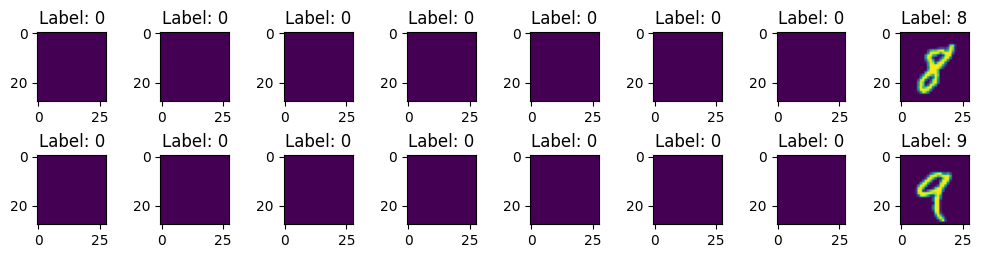

KeyboardInterrupt: 

In [35]:
nrows = 2
ncols = sequence_length // 2
for seq_len in range(1, len(values)):
    curr_context_inputs = np.copy(context_inputs)
    curr_context_outputs = np.copy(context_outputs)
    curr_context_inputs[:-seq_len] = 0
    curr_context_outputs[:-seq_len] = 0
    fig, axes = plt.subplots(
        nrows,
        ncols,
        figsize=set_size(doc_width_pt, 0.95, (nrows, ncols), False),
        layout="constrained",
    )

    for idx, img in enumerate(curr_context_inputs):
        axes[idx % 2, idx // 2].imshow(img)
        axes[idx % 2, idx // 2].set_title("Label: {}".format(np.argmax(curr_context_outputs[idx])))
    plt.show()

    errors = compute_test_error(test_dataloader, curr_context_inputs, curr_context_outputs)
    print("Test Accuracy: {}%".format((1 - np.mean(errors)) * 100))

# Check Out-of-task Performance

In [ ]:
# context_inputs, context_outputs, queries, labels = train_dataset[0]
# print(
#     context_inputs.shape,
#     context_outputs.shape,
#     queries.shape,
#     labels.shape
# )



In [ ]:
dataset_to_use = train_dataset
# dataset_to_use = test_dataset

# for sample_idx in np.arange(28, len(dataset_to_use), 29):
for sample_idx in np.arange(0, len(dataset_to_use), 29):
    context_inputs, context_outputs, queries, labels = dataset_to_use[sample_idx]
    outputs, _ = model.forward(
        params[CONST_MODEL_DICT][CONST_MODEL],
        queries.numpy()[None],
        {
            CONST_CONTEXT_INPUT: context_inputs[None],
            CONST_CONTEXT_OUTPUT: context_outputs[None],
        }
    )

    nrows = 2
    ncols = len(context_inputs) // 2
    fig, axes = plt.subplots(
        nrows,
        ncols,
        figsize=set_size(doc_width_pt, 0.95, (nrows, ncols), False),
        layout="constrained",
    )

    for idx, img in enumerate(context_inputs):
        axes[idx % 2, idx // 2].imshow(img)
        axes[idx % 2, idx // 2].set_title("Label: {}".format(np.argmax(context_outputs[idx])))
    plt.show()

    plt.title("Prediction: {} - Label: {}".format(np.argmax(outputs[0, :dataset_to_use.output_dim[0]]), np.argmax(labels)))
    plt.imshow(queries[0])
    plt.show()

In [ ]:
assert 0

# Check Latent

In [ ]:
def get_latent(params, inputs, carries):
    cnn_outs, cnn_states = CNNModule(
        config.model_config.features,
        config.model_config.kernel_sizes,
        get_activation(CONST_RELU),
    ).apply(
        {"params": params[CONST_MODEL_DICT][CONST_MODEL][CONST_CNN][CONST_PARAMS]},
        inputs,
        capture_intermediates=True,
        mutable=["cnn_latents"]
    )

    cnn_outs = cnn_outs.reshape((len(cnn_outs), -1))

    _, mlp_states = MLPModule(
        config.model_config.layers,
        get_activation(CONST_RELU),
        get_activation(CONST_IDENTITY),
    ).apply(
        {"params": params[CONST_MODEL_DICT][CONST_MODEL][CONST_MLP][CONST_PARAMS]},
        cnn_outs,
        capture_intermediates=True,
        mutable=["mlp_latents"]
    )

    latents = OrderedDict()
    for (states, key) in [
        (cnn_states, "cnn_latents"),
        (mlp_states, "mlp_latents"),
    ]:
        for state, state_val in states[key].items():
            latents[state] = state_val
    return latents

In [ ]:
def plot(mlp_1_latents, labels, step):
    os.makedirs("./imgs/{}".format(exp_name), exist_ok=True)
    nrows = 1
    ncols = 2
    fig, axes = plt.subplots(
        nrows,
        ncols,
        figsize=set_size(doc_width_pt, 0.95, (nrows, ncols), False),
        layout="constrained",
    )

    unique_classes = np.unique(labels["train"])

    for ax_i, key in enumerate(("train", "test")):
        for class_i in unique_classes:
            class_idxes = np.where(labels[key] == class_i)[0]
            axes[ax_i].scatter(
                mlp_1_latents[key][class_idxes, 0],
                mlp_1_latents[key][class_idxes, 1],
                label="Class {}".format(class_i) if ax_i == 0 else "",
                alpha=0.5,
                s=1
            )
        axes[ax_i].set_title(key)
    fig.legend()
    fig.suptitle("Model @ epoch {}".format(step))
    fig.tight_layout()
    plt.savefig("./imgs/{}/nc-step_{:08d}.png".format(exp_name, step), format="png", bbox_inches="tight", dpi=600)
    plt.close()

In [ ]:
batch_size = 300
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
)

In [ ]:
results = {}
for (step, params) in all_params:
    mlp_1_latents = {
        "train": [],
        "test": [],
    }
    labels = {
        "train": [],
        "test": [], 
    }
    all_latents = {
        "train": {},
        "test": {}
    }

    for key, dataloader in (("train", train_dataloader), ("test", test_dataloader)):
        for batch_i, (inputs, carries, outputs, _) in enumerate(iter(dataloader)):
            latents = get_latent(params, inputs, carries)
            mlp_1_latents[key].append(latents["mlp_{}".format(len(config.model_config.layers) - 1)][0])
            labels[key].append(outputs)
            for k in latents:
                all_latents[key].setdefault(k, [])
                all_latents[key][k].append(latents[k][0])

        mlp_1_latents[key] = np.concatenate(mlp_1_latents[key], axis=0)
        labels[key] = np.concatenate(labels[key], axis=0)
        all_latents[key] = {k: np.concatenate(all_latents[key][k]) for k in all_latents[key]}
    plot(mlp_1_latents, labels, step)
    results[step] = {
        "latents": all_latents,
        "labels": labels,
    }

In [ ]:
import imageio

with imageio.get_writer("./nc-{}.gif".format(exp_name), mode='I', duration=100) as writer:
    img_dir = "./imgs/{}".format(exp_name)
    for filename in sorted(os.listdir(img_dir)):
        if not filename.startswith("nc-step"):
            continue
        image = imageio.imread(os.path.join(img_dir, filename))
        writer.append_data(image)

# Check Neural Collapse Properties

In [ ]:
nc_results = {}
for step, step_res in results.items():
    valid_classes = np.unique(step_res["labels"]["train"])
    nc_results.setdefault(step, {})
    # for phase, phase_latents in step_res["latents"].items():
    for phase in ["train"]:
        phase_latents = step_res["latents"][phase]
        for layer, curr_latents in phase_latents.items():
            if layer.startswith("cnn"):
                continue
            nc_results[step].setdefault(layer, {})
            nc_results[step][layer]["global_means"] = np.mean(curr_latents, axis=0)
            offset = (curr_latents - nc_results[step][layer]["global_means"][None])[..., None]
            nc_results[step][layer]["train_total_cov"] = np.mean(offset @ np.transpose(offset, (0, 2, 1)), axis=0)

            nc_results[step][layer]["class_means"] = {}
            for class_i in valid_classes:
                class_idxes = np.where(step_res["labels"][phase] == class_i)[0]
                nc_results[step][layer]["class_means"][class_i] = np.mean(curr_latents[class_idxes], axis=0)
            between_class_offset = np.vstack([nc_results[step][layer]["class_means"][class_i] - nc_results[step][layer]["global_means"] for class_i in valid_classes])[..., None]
            nc_results[step][layer]["between_class_cov"] = np.mean(between_class_offset @ np.transpose(between_class_offset, (0, 2, 1)), axis=0)
            nc_results[step][layer]["within_class_cov"] = np.mean(
                np.concatenate(
                    [curr_latents[np.where(step_res["labels"][phase] == class_i)[0]] - nc_results[step][layer]["class_means"][class_i][None] for class_i in valid_classes],
                    axis=0
                ),
                axis=0
            )
            

In [ ]:
jax.tree_map(lambda x: x.shape, nc_results[step])

## NC1

In [ ]:
nrows = len(nc_results[1])
ncols = 1
fig, axes = plt.subplots(
    nrows,
    ncols,
    figsize=set_size(doc_width_pt, 0.95, (nrows, ncols), False),
    layout="constrained",
)


for ax_i, layer in enumerate(nc_results[1]):
    within_class_cov = np.array([nc_results[step][layer]["within_class_cov"] for step in nc_results])
    for dim_i in range(within_class_cov.shape[1]):
        axes[ax_i].plot(
            nc_results.keys(),
            within_class_cov[:, dim_i],
            label="dim. {}".format(dim_i)
        )
    axes[ax_i].set_title(layer)
    axes[ax_i].legend()
fig.suptitle("NC 1 Condition")
plt.show()
plt.close()